<a href="https://colab.research.google.com/github/joshualin24/EEG_demo/blob/main/EEGBCI_Data_Utilities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploration of EEGBCI Motor Movement/Imagery Dataset

This notebook inspects the [EEGBCI dataset](http://www.ncbi.nlm.nih.gov/pubmed/15188875) on [PhysioNet](https://www.ahajournals.org/doi/10.1161/01.CIR.101.23.e215) and provides a few utilities to bridge between the [MNE](https://mne.tools/stable/index.html) neurophysiological data structure and common ML libraries such as Pandas and PyTorch. Detailed data description and experimental protocol can be found [here](https://physionet.org/content/eegmmidb/1.0.0/#files-panel).

# Prerequisite

In [1]:
!pip install mne

In [2]:
import mne
import pandas as pd
import torch
from torch.utils.data import Dataset
from typing import Optional, Callable

# Data Acquisition

In [3]:
SUBJECT = 1
RUNS = [1, 3]

raw_fnames = mne.datasets.eegbci.load_data(SUBJECT, RUNS, path='./')
raw_1 = mne.io.read_raw_edf(raw_fnames[0])  # raw data at rest state
raw_3 = mne.io.read_raw_edf(raw_fnames[1])  # raw data with motor movement

Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [4]:
raw_1

<RawEDF | S001R01.edf, 64 x 9760 (61.0 s), ~65 kB, data not loaded>

Using matplotlib as 2D backend.


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


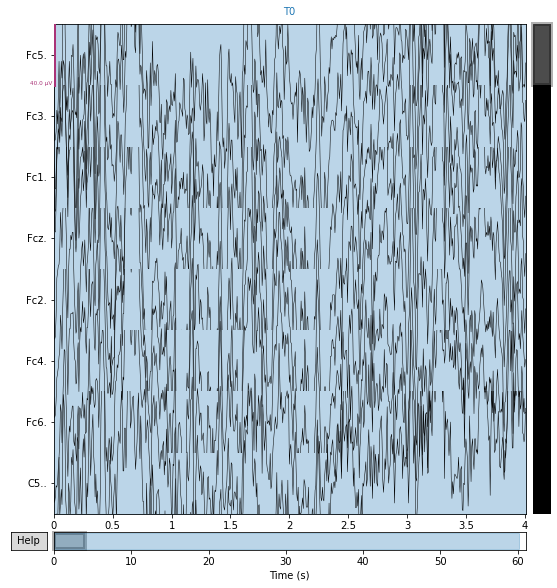

In [5]:
raw_1.plot(duration=4.0, n_channels=8).show()

In [6]:
raw_3

<RawEDF | S001R03.edf, 64 x 20000 (125.0 s), ~65 kB, data not loaded>

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


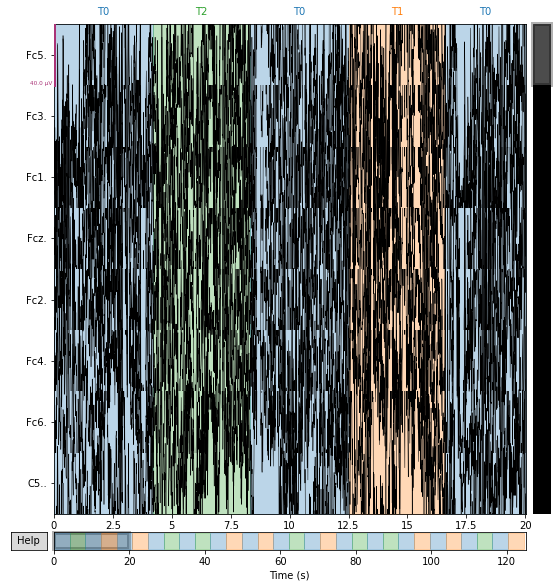

In [7]:
raw_3.plot(duration=20.0, n_channels=8).show()

# Extract Windows from Raw Data

In [8]:
EVENT_ID = {  # integer identifier of experimental tasks/events
    'rest/eye-open': 0,
    'rest/eye-closed': 1,
    'movement/left/fist': 2,
    'movement/right/fist': 3,
    'imagery/left/fist': 4,
    'imagery/right/fist': 5,
    'movement/both/fist': 6,
    'movement/both/foot': 7,
    'imagery/both/fist': 8,
    'imagery/both/foot': 9
}
EVENT_MAPPING = {ind: key for key, ind in EVENT_ID.items()}
DURATION = 4  # duration of experimental tasks/events
BASELINE_DURATION = 0.2  # duration of baseline (for drift correction)

In [9]:
event_id = {
    'T1': EVENT_ID['movement/left/fist'],
    'T2': EVENT_ID['movement/right/fist']
}
events, event_id = mne.events_from_annotations(raw_3, event_id=event_id)

Used Annotations descriptions: ['T1', 'T2']


In [10]:
metadata = pd.DataFrame({
    'start': events[:, 0] / raw_3.info['sfreq'],  # start time of windows
    'task': events[:, -1],  # identifier of experimental tasks
    'subject': 1,
    'run': 3
})

In [11]:
epochs = mne.Epochs(
    raw_3,
    events,
    event_id={EVENT_MAPPING[ind]: ind for ind in event_id.values()},
    tmin=-BASELINE_DURATION,
    tmax=DURATION,
    metadata=metadata
)

Adding metadata with 4 columns
Replacing existing metadata with 4 columns
15 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated


In [12]:
epochs['left']  # parse windows associated with left fist

Number of events,8
Events,movement/left/fist: 8
Time range,-0.200 – 4.000 sec
Baseline,-0.200 – 0.000 sec


Loading data for 15 events and 673 original time points ...
0 bad epochs dropped
Loading data for 15 events and 673 original time points ...
Loading data for 3 events and 673 original time points ...


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


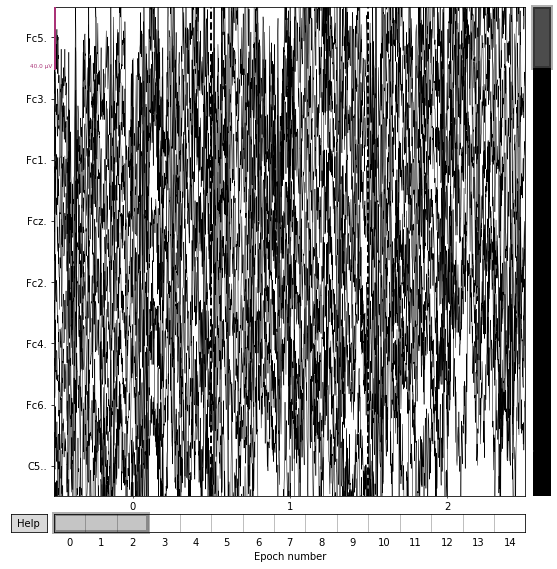

In [13]:
epochs.plot(n_epochs=3, n_channels=8).show()

In [14]:
fixed_length_epochs = mne.make_fixed_length_epochs(raw_1, duration=4.0, id=0)

Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated


Loading data for 15 events and 640 original time points ...
0 bad epochs dropped
Loading data for 15 events and 640 original time points ...
Loading data for 3 events and 640 original time points ...


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


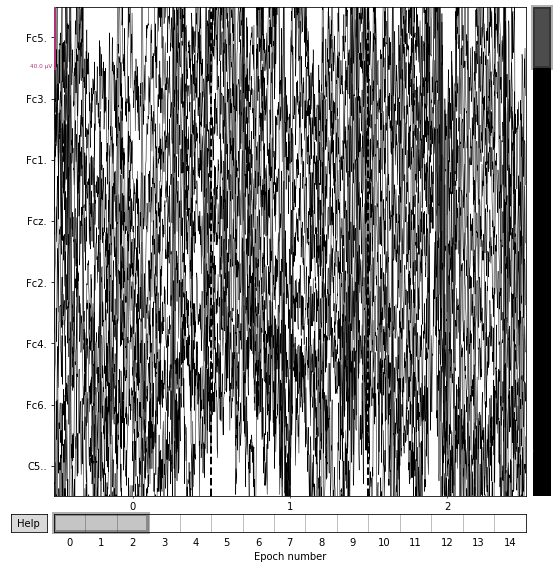

<bound method Figure.show of <MNEBrowseFigure size 576x576 with 4 Axes>>

In [15]:
fixed_length_epochs.plot(n_epochs=3, n_channels=8).show

# Utilities

In [16]:
def extract_windows(
    raw: mne.io.Raw,
    subject: int,
    run: int,
    event_id: dict,
    duration: float = 4.0,
    baseline_duration: float = 0.2
):
    """
    Return windows/epochs extracted from raw data.

    Arguments
    ---------
        raw: Raw data
        subject: Subject of recording
        run: Experimental run
        event_id: Mapping from tasks/events to integer identifiers
        duration: duration of windows that capture responses to tasks/events
        baseline_duration: duration of baseline for drift correction
    """
    events, focal_event_id = get_events(raw, run, event_id)
    metadata = pd.DataFrame({
        'start': events[:, 0] / raw_3.info['sfreq'],  # start time of windows
        'task': events[:, -1],  # identifier of experimental tasks
        'subject': subject,
        'run': run
    })
    event_mapping = {ind: key for key, ind in event_id.items()}
    return mne.Epochs(
        raw,
        events,
        event_id={event_mapping[ind]: ind for ind in focal_event_id.values()},
        tmin=-baseline_duration,
        tmax=duration,
        metadata=metadata
    )


def get_events(
    raw: mne.io.Raw,
    run: int,
    event_id: dict,
    fixed_length_duration: float = 4.0
):
    """
    Return tuple of events and their integer-identifier-mapping according to
    the experimental run.

    Argmuments
    ----------
        raw: Raw data
        run: Experimental run
        event_id: Mapping from tasks/events to integer identifiers
        fixed_length_duration: Duration to create fixed-length events
    """
    if run in (1, 2):
        events = mne.make_fixed_length_events(
            raw,
            id=run,
            duration=fixed_length_duration
        )
        return events, {'T0': run}
    elif run in (3, 7, 11):
        event_id = {
            'T1': event_id['movement/left/fist'],
            'T2': event_id['movement/right/fist']
        }
        return mne.events_from_annotations(raw, event_id=event_id)
    elif run in (4, 8, 12):
        event_id = {
            'T1': event_id['imagery/left/fist'],
            'T2': event_id['imagery/right/fist']
        }
        return mne.events_from_annotations(raw, event_id=event_id)
    elif run in (5, 9, 13):
        event_id = {
            'T1': event_id['movement/both/fist'],
            'T2': event_id['movement/both/foot']
        }
        return mne.events_from_annotations(raw, event_id=event_id)
    elif run in (6, 10, 14):
        event_id = {
            'T1': event_id['imagery/both/fist'],
            'T2': event_id['imagery/both/foot']
        }
        return mne.events_from_annotations(raw, event_id=event_id)
    else:
        raise ValueError('invalid experimental run.')

In [17]:
EVENT_ID = {  # integer identifier of experimental tasks/events
    'rest/eye-open': 0,
    'rest/eye-closed': 1,
    'movement/left/fist': 2,
    'movement/right/fist': 3,
    'imagery/left/fist': 4,
    'imagery/right/fist': 5,
    'movement/both/fist': 6,
    'movement/both/foot': 7,
    'imagery/both/fist': 8,
    'imagery/both/foot': 9
}


def eegbci_epochs(
    subjects: list,
    runs: list,
    dir: str = './',
    select: Optional[str] = None,
    **kwargs
):
    """
    Return extracted windows/epochs from the EEGBCI motor movement/imagery data.

    Arguments
    ---------
        subjects: List of subjects of interest
        runs: List of experimental runs for each subject
        dir: Root directory path to the EEGBCI data
        select: Key to select a part of extracted windows/epochs
        kwargs: Keyword arguments passed to extract windows
    """
    epochs_list = [
        extract_windows(
            mne.io.read_raw_edf(mne.datasets.eegbci.load_data(subject, run, path=dir)[0]),
            subject,
            run,
            EVENT_ID,
            **kwargs
        ) for subject in subjects for run in runs
    ]
    epochs = mne.concatenate_epochs(epochs_list, add_offset=False)
    return epochs if select is None else epochs[select]

In [18]:
def eegbci_dataframe(subjects: list, runs: list, **kwargs):
    """
    Return dataframe and metadata of extracted windows from the EEGBCI motor
    movement/imagery data.

    Arguments
    ---------
        subjects: List of subjects of interest
        runs: List of experimental runs for each subject
        kwargs: Keyword arguments passed to extract windows
    """
    epochs = eegbci_epochs(subjects, runs, **kwargs)
    return epochs.to_data_frame(), epochs.metadata

In [19]:
class EEGBCIDataset(Dataset):
    """Dataset of the EEGBCI motor movement/imagery data."""

    def __init__(
        self,
        subjects: list,
        runs: list,
        get_label: Callable,
        transform: Callable = None,
        target_transform: Callable = None,
        **kwargs
    ):
        """
        Arguments
        ---------
            subjects: List of subjects of interest
            runs: List of experimental runs for each subject
            get_label: Function to extract label from metadata
            transform: Transformation upon data
            target_transform: Transformation upon labels
            kwargs: Keyword arguments passed to extract windows
        """
        super().__init__()
        self.windows = eegbci_epochs(subjects, runs, **kwargs)
        self.get_label = get_label
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.windows)
    
    def __getitem__(self, ind):
        window = self.windows[ind]
        data, label = window.get_data()[0], self.get_label(window.metadata)
        if self.transform: data = self.transform(data)
        if self.target_transform: label = self.target_transform(label)
        return data, label

# Scratch

In [20]:
temp_dataset = EEGBCIDataset([1], [1, 3], lambda meta: meta['task'].values[0])

Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
15 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
15 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 15 events and 673 original time points ...
1 bad epochs dropped
Loading data for 15 events and 673 original time points ...
0 bad epochs dropped
Load

<ipython-input-17-42d0eb51089e>:42: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs(epochs_list, add_offset=False)


In [21]:
data, label = temp_dataset[2]
print('Data: \n', data)
print('Label: \n', label)

Data: 
 [[-7.48484848e-06  3.51515152e-06  1.05151515e-05 ... -1.44848485e-05
   3.65151515e-05  7.55151515e-05]
 [-6.66666667e-06  2.33333333e-06  2.23333333e-05 ... -4.66666667e-06
   4.13333333e-05  7.13333333e-05]
 [-7.51515152e-06  1.04848485e-05  3.44848485e-05 ... -1.05151515e-05
   3.34848485e-05  6.94848485e-05]
 ...
 [-5.21515152e-05 -3.01515152e-05 -1.15151515e-06 ...  1.48484848e-05
   4.08484848e-05  6.08484848e-05]
 [-7.03030303e-06  1.19696970e-05  4.29696970e-05 ...  3.89696970e-05
   5.89696970e-05  7.79696970e-05]
 [-5.30000000e-05 -3.00000000e-05 -1.10000000e-05 ...  3.20000000e-05
   6.10000000e-05  9.30000000e-05]]
Label: 
 1
